In [61]:
import pandas as pd
import seaborn as sns
import numpy as np
import os

from matplotlib import pyplot as plt
from dotenv import load_dotenv

from scripts.merge import merge_cols
from scripts.convert import convert_to_holy_metric, find_unit

load_dotenv()
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100


In [62]:
# Files

twenty_fifteen_bm = "data/2015-building-energy-benchmarking.csv"
twenty_sixteen_bm = "data/2016-building-energy-benchmarking.csv"


In [63]:
df_fifteen = pd.read_csv(twenty_fifteen_bm, dtype="unicode", low_memory=False)
df_sixteen = pd.read_csv(twenty_sixteen_bm, dtype="unicode", low_memory=False)


In [64]:
print("info : ", df_fifteen.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype 
---  ------                                                         --------------  ----- 
 0   OSEBuildingID                                                  3340 non-null   object
 1   DataYear                                                       3340 non-null   object
 2   BuildingType                                                   3340 non-null   object
 3   PrimaryPropertyType                                            3340 non-null   object
 4   PropertyName                                                   3340 non-null   object
 5   TaxParcelIdentificationNumber                                  3338 non-null   object
 6   Location                                                       3340 non-null   object
 7   CouncilDistrictCode                                            3340 n

In [65]:
print("info : ", df_sixteen.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   OSEBuildingID                    3376 non-null   object
 1   DataYear                         3376 non-null   object
 2   BuildingType                     3376 non-null   object
 3   PrimaryPropertyType              3376 non-null   object
 4   PropertyName                     3376 non-null   object
 5   Address                          3376 non-null   object
 6   City                             3376 non-null   object
 7   State                            3376 non-null   object
 8   ZipCode                          3360 non-null   object
 9   TaxParcelIdentificationNumber    3376 non-null   object
 10  CouncilDistrictCode              3376 non-null   object
 11  Neighborhood                     3376 non-null   object
 12  Latitude                         3

In [66]:
id_fifteen_list = list(df_fifteen["OSEBuildingID"])
id_sixteen_list = list(df_sixteen["OSEBuildingID"])

only_in_fifteen = [ident for ident in id_fifteen_list if ident not in id_sixteen_list]
only_in_sixteen = [ident for ident in id_sixteen_list if ident not in id_fifteen_list]

print(
    f"""{len(only_in_fifteen)} batiments ne sont présents que dans le benchmark 2015,\
 et {len(only_in_sixteen)} batiments ne sont présents que dans le benchmark 2016 """
  )


56 batiments ne sont présents que dans le benchmark 2015, et 92 batiments ne sont présents que dans le benchmark 2016 


In [67]:
col_onl_fifteen = [col for col in df_fifteen.columns if col not in df_sixteen.columns]

col_onl_sixteen = [col for col in df_sixteen.columns if col not in df_fifteen.columns]

print("Nombre de variables non communes aux deux datasets : ", len(col_onl_fifteen) + len(col_onl_sixteen))


Nombre de variables non communes aux deux datasets :  19


In [68]:
print(col_onl_sixteen)


['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude', 'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


In [69]:
print(col_onl_fifteen)


['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'City Council Districts', 'SPD Beats', 'Zip Codes']


## Premier constat : 

- 1 : Les dataset n'affichent des valeurs manquantes pour des variables secondaires (i.e. : SecondLargestPropertyUseType)
- 2 : Certaines propriétés ne sont présentes que dans un des deux dataset : elles devront être ignorés si l'on utilise une analyse d'évolution dans le temps
- 3 : Certaines variables ne sont pas presentes dans les deux datasets. (Ou changement de denomination : Address -> Location ?, Typos : Zip Code vs Zipcode)
- 4 : Les variables : city et state peuvent être supprimées : toutes les propriétés se trouvent à Seattle, dans l'Etat de Washington. Inutile d'alourdir les datasets.
- 5 : 56 batiments ne sont présents que dans le benchmark 2015, et 92 batiments ne sont présents que dans le benchmark 2016. Ils seront ignorés.

<hr> 

## Allegement et conversions :

- 1 : Plusieurs variables sont inutiles au datasets en general (Droplist)
- 2 : Certaines variables sont inutiles à l'étude et alourdissent inutilement le dataset mais peuvent être pertinentes pour décrire le batiment ou obtenir plus d'informations, elles sont écartées (df_meta)
- 3 : Le format d'adresse sur les données de 2015 est différent de celles de 2016 : compression des données de 2016 pour conformer au modèle du dataset 2015 (compress cols)
- 4 : Conversion des données au système métrique / international


In [70]:
rename_sixteen = {
    "Comments": "Comment",
    "TotalGHGEmissions": "GHGEmissions(MetricTonsCO2e)",
    "GHGEmissionsIntensity": "GHGEmissionsIntensity(kgCO2e/ft2)",
    }

droplist = [
    "Zip Codes", "Zipcode", "SPD Beats", "2010 Census Tracts", "City Council Districts",
    "Seattle Police Department Micro Community Policing Plan Areas", "OtherFuelUse(kBtu)",  # OtherFuelUse not present in both datasets
    "SPD Beats", "CouncilDistrictCode", "Outlier", "DataYear", "ZipCode", "NaturalGas(therms)",  # Natural gas already present in another unit
    ]

# Columns not relevant to study but informative on the properties
meta_df_cols = [
    "TaxParcelIdentificationNumber", "YearsENERGYSTARCertified", "Comment", "Location", "OSEBuildingID",
    "PrimaryPropertyType", "PropertyName", "YearBuilt"
    ]

meta_keep = ["OSEBuildingID", "PrimaryPropertyType", "PropertyName", "YearBuilt"]

compress_cols = ["Address", "City", "State", "Latitude", "Longitude"]


In [71]:
df_fifteen.drop(columns=droplist, errors="ignore", inplace=True)
df_sixteen.drop(columns=droplist, errors="ignore", inplace=True)


In [72]:
df_sixteen["Location"] = np.nan

merge_cols(origin_col_list=compress_cols, target_col_name="Location", dataframe=df_sixteen)

df_sixteen.drop(columns=compress_cols, inplace=True)


In [73]:
df_sixteen.rename(columns=rename_sixteen, inplace=True)

for col in df_sixteen.columns:
    if col not in df_fifteen.columns:
        raise BaseException("Mismatch")


In [74]:
meta_df_fifteen = df_fifteen[meta_df_cols]
meta_df_sixteen = df_sixteen[meta_df_cols]

meta_drop = [col for col in meta_df_cols if col not in meta_keep]

df_fifteen.drop(columns=meta_drop, inplace=True)
df_sixteen.drop(columns=meta_drop, inplace=True)


In [75]:
unit_stop_chars = ["(", ")", "GFA"]

manual_ignore = ["Electricity(kWh)", "GHGEmissions(MetricTonsCO2e)", "GHGEmissionsIntensity(kgCO2e/ft2)"]

unit_cols = [col for col in df_fifteen.columns if (any(char in col for char in unit_stop_chars) and col not in manual_ignore)]


In [76]:
unit_dict = dict.fromkeys(unit_cols)

for col in unit_dict.keys(): 
    unit = find_unit(var_name=col, convert=True)["converted_unit"]

    if "GFA" in col:
        new_name = col.replace("GFA", "Area(SquareMetre)")
    elif ("("and ")") in col:
        start, end = col.find("("), col.find(")")
        before = col[:start + 1]
        after = col[end:]
        new_name = f"{before}{unit}{after}"
    
    df_fifteen[new_name] = np.nan
    df_sixteen[new_name] = np.nan
    unit_dict[col] = new_name

for key, value in unit_dict.items():

    for index, series in df_fifteen.iterrows():
        df_fifteen.at[index, value] = convert_to_holy_metric(data=series[key], var_name=key)
    for index, series in df_sixteen.iterrows():
        df_sixteen.at[index, value] = convert_to_holy_metric(data=series[key], var_name=key)

df_fifteen.drop(columns=unit_dict.keys(), inplace=True)
df_sixteen.drop(columns=unit_dict.keys(), inplace=True)


In [77]:
# Suppression des batiments non communs aux deux datasets via leur ID

df_fifteen = df_fifteen[~df_fifteen["OSEBuildingID"].isin(only_in_fifteen)]

df_sixteen = df_sixteen[~df_sixteen["OSEBuildingID"].isin(only_in_sixteen)]


## Analyse des données :
- 1.a : Représentation des batiments en fonction de leurs dates de construction.
- 1.b : Visualisation des statistiques principales de la variable : Energie par metre carré
- 1.c : Paire 1 : Date de construction et utilisation en energie par metre carré.
- 2.a : Repartition de la note Energy Star au sein des données.
- 2.b : Paire 2 : Note Energy Star en fonction de l'energie par metre carré.
- 3 : Paire 3 : Energy Star en fonction de l'année de construction.
- 4 : Représentation Property Type/Utilisation Energie

### Cette analyse permettra de :
 - Visualiser "l'age" du paysage de Seattle
 - Contextualiser la mesure de la consommation d'énergie au metre carré, et sa possible relation avec l'age des batiments
 - Avoir une meilleure comprehension de la variable Energy Star et de la présenter face à l'age des batiments et de leur consommation en energie

## 1 : L'age des batiments et leur consommation en energie
### 1.a : L'age du paysage de Seattle

In [78]:
# We can use df_16 since the data is more recent for energy use and didnt change for construction date

data_age = list(df_sixteen["YearBuilt"].astype(int))
oldest = min(data_age)
youngest = max(data_age)

print(f"Le plus ancien batiment date de {oldest}, le plus récent (en 2016) date de {youngest}")


Le plus ancien batiment date de 1900, le plus récent (en 2016) date de 2015


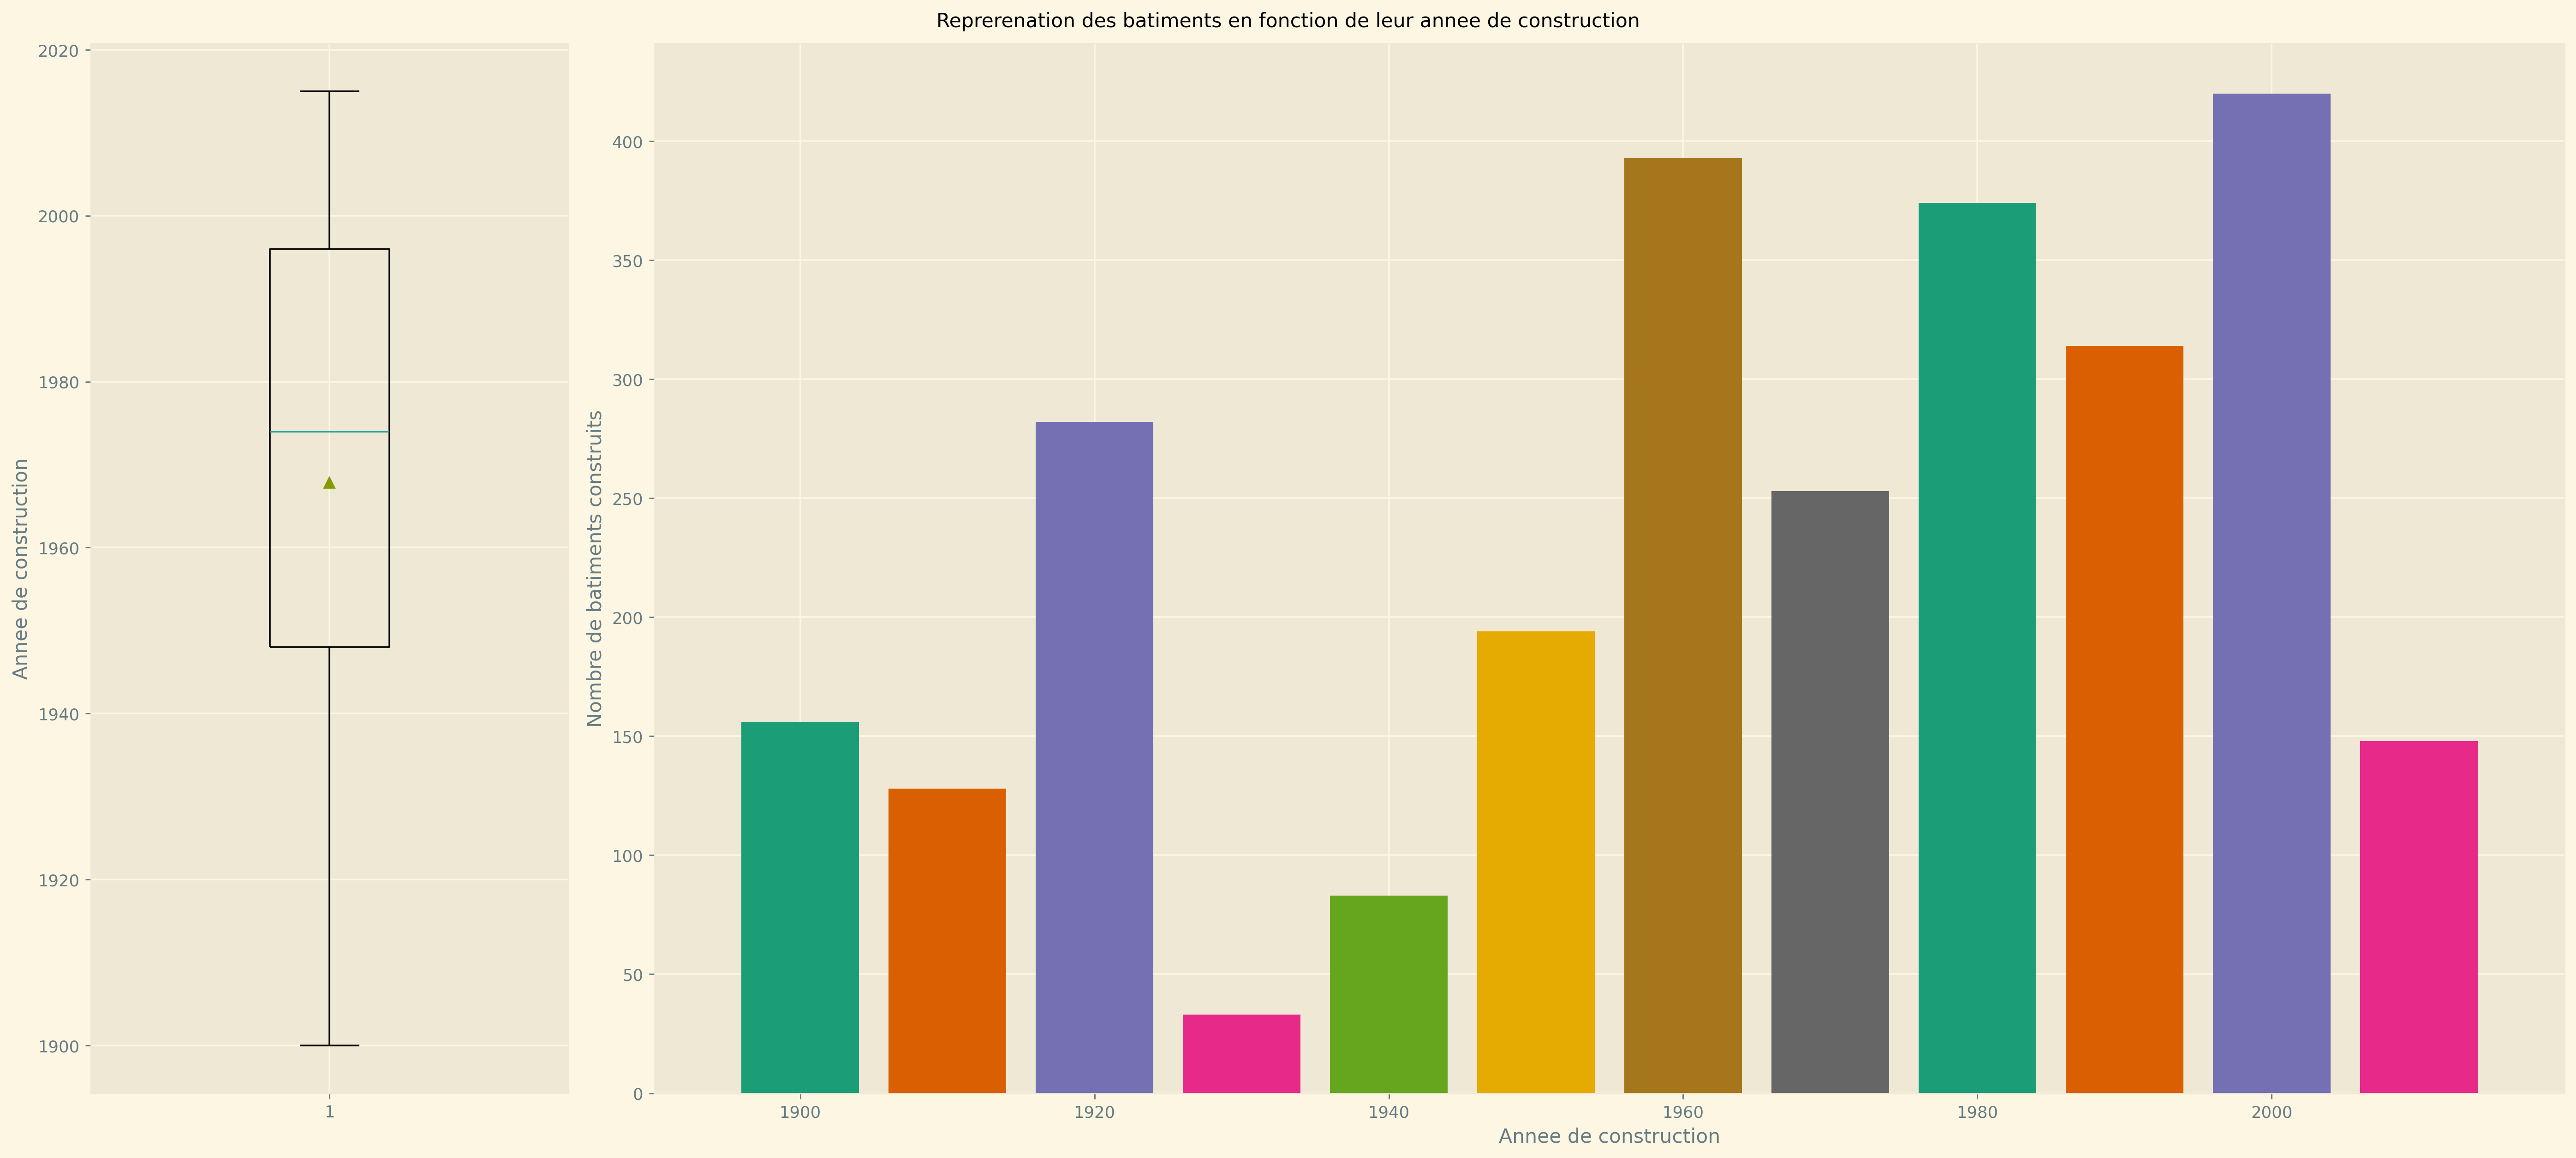

In [79]:
decades = np.arange(1900, 2020, 10)

building_per_decade = dict.fromkeys(decades)

for decade in building_per_decade.keys():
    built = len([year for year in data_age if (year > decade and year < decade + 10)])
    building_per_decade[decade] = built

used_cmap = plt.get_cmap("Dark2")

fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(22, 10),
    gridspec_kw={"width_ratios": [1, 4]},
    dpi=pc_dpi
    )

ax1.boxplot(data_age, showmeans=True, widths=0.25)

ax2.bar(building_per_decade.keys(), height=building_per_decade.values(), width=8, color=used_cmap.colors)
# ax2 lineplot

###
# Titles & Labels
ax1.set_ylabel("Annee de construction")
ax2.set_ylabel("Nombre de batiments construits")
ax2.set_xlabel("Annee de construction")
fig.suptitle("Reprerenation des batiments en fonction de leur annee de construction")
fig.tight_layout()
#
###

plt.show()


Comment Zone

## 1.b Visualisation des statistiques principales de la variable : Energie par metre carré

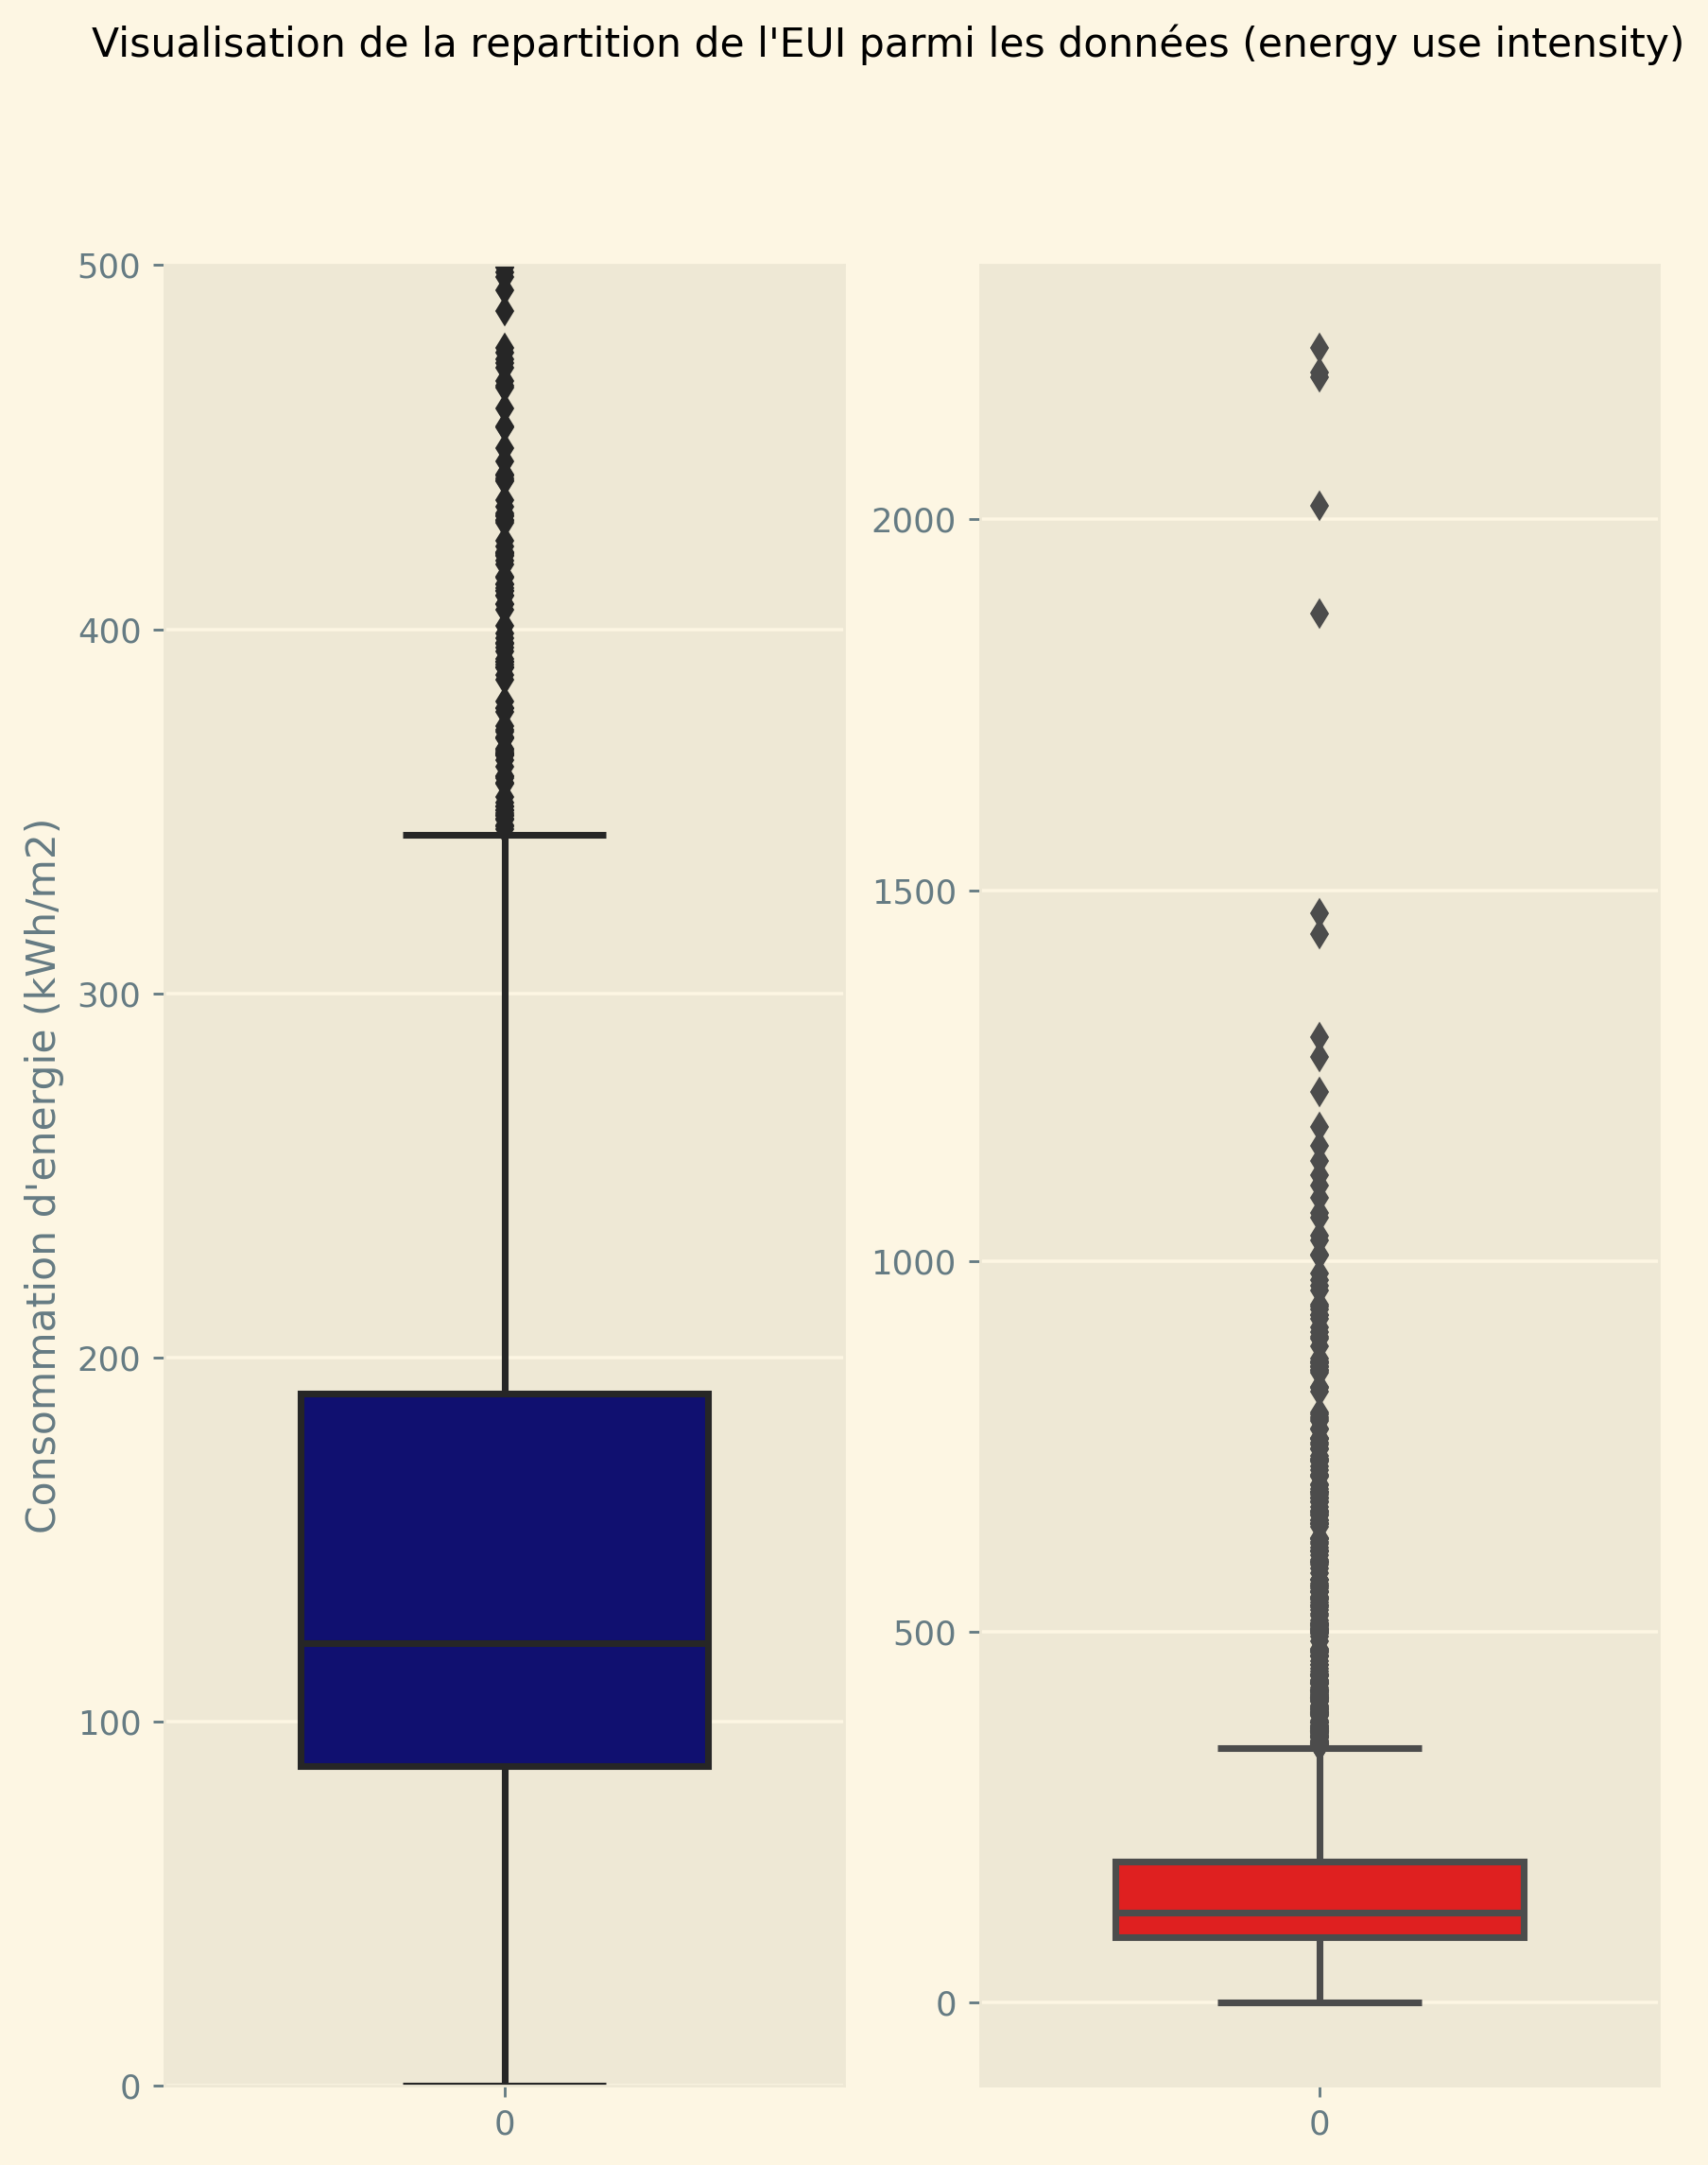

count    3278.000000
mean      170.962418
std       170.593548
min         0.000000
25%        87.697600
50%       121.451715
75%       190.142911
max      2231.241469
Name: SiteEUI(kWh/m2), dtype: float64


In [105]:
fig, (ax1, ax2) = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(8, 10),
    dpi=pc_dpi,
    )

site_eui_data = list(df_sixteen["SiteEUI(kWh/m2)"].values.astype(float))

sns.boxplot(data=site_eui_data, width=0.6, ax=ax1, color="navy")
ax1.set_ylim(0, 500)  # High number of outliers, cf describe
sns.boxplot(data=site_eui_data, width=0.6, ax=ax2, color="red")
# fig.tight_layout()

###
# Titles/Lables
ax1.set_ylabel("Consommation d'energie (kWh/m2)")
fig.suptitle("Visualisation de la repartition de l'EUI parmi les données (energy use intensity)")
#
###

plt.show()

print(df_sixteen["SiteEUI(kWh/m2)"].astype(float).describe())


### Analyse :

- 1 : Les outliers sont extrèmement nombreux, uniquement dans les utilisations "hautes"
- 2 : La majorité des batiments ont une EUI entre 87 et 190 kWh/m2, 170 en moyenne.
- 3 : L'élimination de batiments via la methode interquartile peut être viable, la reduction de dimension via ACP peut également être une piste

### 1.c : Paire 1 : Date de construction et utilisation en energie par metre carré.

In [99]:
uniques = df_fifteen["PrimaryPropertyType"].unique()
unique_property_type_dict = dict.fromkeys(uniques)
for unique in unique_property_type_dict.keys():
    unique_property_type_dict[unique] = len(df_fifteen[df_fifteen["PrimaryPropertyType"] == unique])

unique_property_type_dict


{'Hotel': 73,
 'Other': 251,
 'Mid-Rise Multifamily': 535,
 'Mixed Use Property': 125,
 'K-12 School': 134,
 'College/University': 22,
 'Small- and Mid-Sized Office': 290,
 'Self-Storage Facility\n': 27,
 'Distribution Center': 2,
 'Large Office': 168,
 'Retail Store': 97,
 'Senior Care Community': 43,
 'Medical Office': 40,
 'Hospital': 10,
 'Residence Hall/Dormitory': 15,
 'Non-Refrigerated Warehouse': 185,
 'Distribution Center\n': 51,
 'SPS-District K-12': 4,
 'Worship Facility': 71,
 'Low-Rise Multifamily': 976,
 'Supermarket/Grocery Store': 36,
 'Laboratory': 1,
 'Self-Storage Facility': 1,
 'Refrigerated Warehouse': 13,
 'High-Rise Multifamily': 103,
 'Restaurant\n': 10,
 'Restaurant': 1}

In [104]:
df_fifteen["PropertyArea(SquareMetre)Total"]

0        8215.787439
1        9621.596241
2       89371.795450
3        5696.814413
4       11138.145466
            ...     
3335     4148.120736
3336     3938.438575
3337    29680.756122
3338     4480.713619
3339     4933.151424
Name: PropertyArea(SquareMetre)Total, Length: 3284, dtype: float64